# Tarea final: **Aplicación de series de tiempo**

### **Grupo 16 - Participantes:**
- **Macarena Beatriz Ramírez - _maca.rm.estudios@gmail.com_**
- **Carlos José Ramírez - _cjramirezt@uc.cl_**
- **David Ernesto Quezada - _davque@gmail.com_**
- **Amauris Germán Renvill - _arenvill@gmail.com_**
- **Lara Sofía Rosenberg - lsrosenberg@uc.cl**

### **Series de Tiempo - Magíster en Ciencia de Datos**
### **Docente: Jonathan Acosta Salazar**

### **Julio de 2024**

-------


## **1. Introducción**

Esta libreta contiene el código relacionado al trabajo final del curso de Series de Tiempo, cuyo informe completo y archivo de datos son entregados en ficheros adjuntos. El objetivo de este trabajo es analizar y modelar una serie de tiempo de $\COMPLETAR$.

## **2. Carga de librerías y datos**

A continuación, se cargan las librerías necesarias para el análisis y se importan los datos a utilizar.

In [3]:
# Carga de librerías (borrar lo que sobre)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ExponentialSmoothing  # por si hiciera falta
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf, plot_residuals_analysis
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error


In [65]:
# Carga de datos y preprocesamiento
data_bitcoin = pd.read_csv('datasets/bitcoin.csv')
data_ipcusa = pd.read_csv('datasets/PriceStats_CPI.csv')
data_uf = pd.read_csv('datasets/UF.csv', sep=";")
data_dolar = pd.read_csv('datasets/Dolar.csv',sep=";")
# acá preprocesemos lo que haga falta: interpolar sobre nulos, eliminar columnas, arreglar formatos, etc.


In [66]:
#Dataset Bitcoin
data_bitcoin['date'] = pd.to_datetime(data_bitcoin['Timestamp'], format='%d-%m-%Y')
data_bitcoin.set_index('date', inplace=True)
data_bitcoin.drop(columns=['Timestamp'], inplace=True)
# data_bitcoin['Close'].plot()
# plt.title('Serie de Tiempo de Bitcoin')
# plt.show()


#Dataset IPC USA
data_ipcusa.set_index('date', inplace=True)
data_ipcusa.drop(columns=['CPI'], inplace=True)
# data_ipcusa['Close'].plot()
# plt.title('Serie de Tiempo de Bitcoin')
# plt.show()

#Datasets Dolar & UF
meses_espanol = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr', 'may': 'May', 'jun': 'Jun',
    'jul': 'Jul', 'ago': 'Aug', 'sept': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}
# Función para reemplazar el nombre del mes
def reemplazar_mes(fecha):
    mes, año = fecha.split('.')
    mes_ingles = meses_espanol[mes]
    return f'{mes_ingles}.{año}'

#Dataset dolar
data_dolar['date'] = data_dolar['Periodo'].apply(reemplazar_mes)
data_dolar['date'] = pd.to_datetime(data_dolar['date'], format='%b.%Y')
data_dolar.set_index('date', inplace=True)
data_dolar.drop(columns=['Periodo'], inplace=True)
data_dolar.columns.values[0] = 'Dolar'
data_dolar.head()
data_dolar['Dolar'] = data_dolar['Dolar'].str.replace(',', '.')
data_dolar['Dolar'] = pd.to_numeric(data_dolar['Dolar'])
# data_dolar['Close'].plot()
# plt.title('Serie de Tiempo de Bitcoin')
# plt.show()

#Dataset UF
data_uf['date'] = data_uf['Periodo'].apply(reemplazar_mes)
data_uf['date'] = pd.to_datetime(data_uf['date'], format='%b.%Y')
data_uf.set_index('date', inplace=True)
data_uf.rename(columns={'Unidad de fomento (UF)': 'UF'}, inplace=True)
data_uf['UF'] = data_uf['UF'].str.replace('.', '')
data_uf['UF'] = data_uf['UF'].str.replace(',', '.')
data_uf['UF'] = pd.to_numeric(data_uf['UF'])
# data_uf['Close'].plot()
# plt.title('Serie de Tiempo de Bitcoin')
# plt.show()


C:\Users\mramirez\AppData\Local\Temp\ipykernel_49476\2898809772.py:46: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_uf['UF'] = data_uf['UF'].str.replace('.', '')


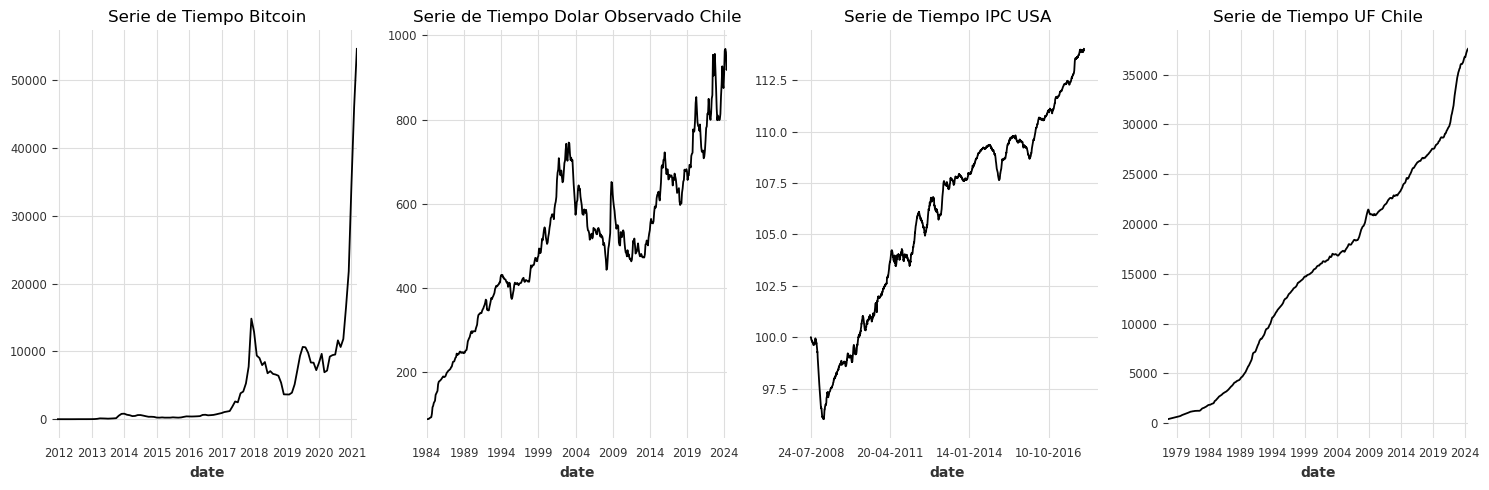

In [67]:

# Crear una figura y subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

# Graficar cada serie de tiempo en su respectivo subplot
data_bitcoin['Close'].plot(ax=axes[0], title='Serie de Tiempo Bitcoin')
data_ipcusa['PriceStats'].plot(ax=axes[2], title='Serie de Tiempo IPC USA')
data_dolar['Dolar'].plot(ax=axes[1], title='Serie de Tiempo Dolar Observado Chile')
data_uf['UF'].plot(ax=axes[3], title='Serie de Tiempo UF Chile')
# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [ ]:
# Creación de la serie de tiempo, con train y test
ts = TimeSeries.from_dataframe(data, 'date', ['value'])
train, test = ts.split_after(pd.Timestamp('2023-01-01'))

## **3. Análisis exploratorio**

En esta sección, se realiza un análisis exploratorio de la serie de tiempo, con el objetivo de identificar patrones y comportamientos que puedan ser útiles para el modelamiento posterior.

In [ ]:
ts.plot()

### **3.1. (si fuera necesario) Transformación de la serie**

Justifiquemos por qué :) acá podríamos hacer una transformación logarítmica, por ejemplo, o una Box-Cox o exponencial o diferenciaciones según fuera necesario.

In [ ]:
# Descomposición
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
decomposition.plot()

In [ ]:
# Transformación logarítmica
ts_log = ts.log()
ts_log.plot()

In [ ]:
# Transformación Box-Cox
ts_boxcox = ts.boxcox()
ts_boxcox.plot()

In [ ]:
# Diferenciación
ts_diff = ts.difference()
ts_diff.plot()

In [ ]:
# Suavizado exponencial
model = ExponentialSmoothing()
model.fit(ts)
ts_exp = model.predict(len(ts))

Algún texto acá que diga por qué elegimos la(s) transformación(es) que elegimos.

### **3.2. Análisis de estacionalidad y estacionariedad**

Aquí realicemos un análisis de la serie con la que creamos que terminaremos trabajando (es decir, luego de transformarla adecuadamente), para chequear que es apta para el modelado.

In [ ]:
# Análisis de estacionalidad
seasonal_period = check_seasonality(ts)
print(f'Seasonal period: {seasonal_period}')

In [ ]:
# Análisis de estacionariedad
adf_test = adfuller(ts.values())
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')


Explicar brevemente qué significa cada uno de los resultados obtenidos, y por qué justifican el uso de esta serie transformada para el modelado.

### **3.2. Autocorrelación y autocorrelación parcial**

In [ ]:
plot_acf(ts)

In [ ]:
plot_pacf(ts)

Explicar brevemente qué se puede inferir de los gráficos de autocorrelación y autocorrelación parcial, y cómo nos ayudarán en el modelado.

## **4. Modelado**

### **4.1. Propuestas de modelos SARIMA**

En base a los análisis realizados en la sección anterior, proponemos los siguientes modelos SARIMA:
- **Modelo 1:** SARIMA(1, 1, 1)(1, 1, 1, 12)
  > Este modelo se propone porque...
- **Modelo 2:** SARIMA(1, 1, 1)(1, 1, 0, 12)
  > Este modelo se propone porque...
- **Modelo 3:** SARIMA(1, 1, 1)(0, 1, 1, 12)
  > Este modelo se propone porque...
- **Modelo 4:** SARIMA(1, 1, 1)(0, 1, 0, 12)
  > Este modelo se propone porque...
- **Modelo 5:** SARIMA(1, 1, 1)(1, 0, 1, 12)
  > Este modelo se propone porque...

In [ ]:
m1 = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
m1.summary()

In [ ]:
m2 = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12)).fit()
m2.summary()

In [ ]:
m3 = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
m3.summary()

In [ ]:
m4 = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 0, 12)).fit()
m4.summary()

In [ ]:
m5 = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12)).fit()
m5.summary()

### **4.3. Evaluación de los modelos propuestos**

Antes de seleccionar modelos, evaluamos su aplicabilidad según si sus residuos son ruido blanco y si cumplen con los supuestos de normalidad y homocedasticidad.

In [ ]:
m1_res = m1.resid
# test de blancura
sm.stats.acorr_ljungbox(m1_res, lags=range(1,12), boxpierce=True).iloc[2:].plot()
# test de normalidad
sm.qqplot(m1_res, line='s')
plt.show()
# test de homocedasticidad
plot_residuals_analysis(m1_res)

In [ ]:
m2_res = m2.resid
# test de blancura
sm.stats.acorr_ljungbox(m2_res, lags=range(1,12), boxpierce=True).iloc[2:].plot()
# test de normalidad
sm.qqplot(m2_res, line='s')
plt.show()
# test de homocedasticidad
plot_residuals_analysis(m2_res)

In [ ]:
m3_res = m3.resid
# test de blancura
sm.stats.acorr_ljungbox(m3_res, lags=range(1,12), boxpierce=True).iloc[2:].plot()
# test de normalidad
sm.qqplot(m3_res, line='s')
plt.show()
# test de homocedasticidad
plot_residuals_analysis(m3_res)

In [ ]:
m4_res = m4.resid
# test de blancura
sm.stats.acorr_ljungbox(m4_res, lags=range(1,12), boxpierce=True).iloc[2:].plot()
# test de normalidad
sm.qqplot(m4_res, line='s')
plt.show()
# test de homocedasticidad
plot_residuals_analysis(m4_res)

In [ ]:
m5_res = m5.resid
# test de blancura
sm.stats.acorr_ljungbox(m5_res, lags=range(1,12), boxpierce=True).iloc[2:].plot()
# test de normalidad
sm.qqplot(m5_res, line='s')
plt.show()
# test de homocedasticidad
plot_residuals_analysis(m5_res)

En base a este análisis, podemos descartar los modelos x, y, z porque...
En cambio, los modelos a, b, c parecen ser adecuados para el modelado porque...

### **4.4. Comparación de los modelos propuestos**

Ahora evaluamos los modelos propuestos, para determinar cuál es el mejor según los criterios de información AIC y BIC en primer lugar, y luego según el error cuadrático medio (MSE) en el conjunto de test.

In [ ]:
models = [m1, m2, m3, m4, m5]
aic = [m.aic for m in models]
bic = [m.bic for m in models]
mse = [mean_squared_error(test.values(), m.forecast(len(test)).values()) for m in models]

results = pd.DataFrame({'AIC': aic, 'BIC': bic, 'MSE': mse})
results

En base a los resultados obtenidos en la sección anterior, seleccionamos el modelo SARIMA(?,?,?)x(x,x,x)[x] que es el que mejor se ajusta a los datos.

In [ ]:
modfinal = models[results['AIC'].idxmin()] # definir mejor jaja

## **5. Predicción**

El modelo final seleccionado es SARIMA(?,?,?)x(x,x,x)[x], y lo utilizamos para predecir los valores de la serie en el conjunto de test. A continuación, mostramos los resultados obtenidos junto con sus intervalos de confianza.

In [ ]:
modfinal = SARIMAX(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
pred = modfinal.forecast(len(test))

# recomponer la serie predicha para graficarla junto con la serie original de entrenamiento
pred = TimeSeries.from_values(pred.values(), start=pd.Timestamp('2023-01-01'), freq='D')
ts.plot(label='train')
pred.plot(label='forecast', lw=2)
plt.legend()
